#Part 1 - Facial Emotion Recognition

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

pathname = '/content/drive/MyDrive/Liesss/'
data = pd.read_csv(pathname+'icml_face_data.csv')

width, height = 48, 48

In [3]:

datapoints = data.iloc[:,-1].tolist()

# getting features for training
X = []
for xseq in datapoints:
    xx = [int(xp) for xp in xseq.split(' ')]
    xx = np.asarray(xx).reshape(width, height)
    X.append(xx.astype('float32'))

X = np.asarray(X)
X = np.expand_dims(X, -1)

# getting labels for training
y = pd.get_dummies(data.iloc[:,0]).values

print(f"X.shape={X.shape}, y.shape={y.shape}")
# storing them using numpy
np.save(pathname+'fdataX', X)
np.save(pathname+'flabels', y)

print("Preprocessing Done")
print("Number of Features: "+str(len(X[0])))
print("Number of Labels: " + str(len(y[0])))
print("Number of examples in dataset:"+str(len(X)))
print("X,y stored in fdataX.npy and flabels.npy respectively")


X.shape=(35887, 48, 48, 1), y.shape=(35887, 7)
Preprocessing Done
Number of Features: 48
Number of Labels: 7
Number of examples in dataset:35887
X,y stored in fdataX.npy and flabels.npy respectively


For later use

In [5]:
import cv2
from google.colab.patches import cv2_imshow

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image

    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    resized = cv2.resize(image, dim, interpolation = inter)
    return resized

def get_face_from_image(img):
  gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
  face = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  faces = face.detectMultiScale(gray, 1.2, 5)
  return (True, faces[0]) if len(faces)>0 else (False, None)

#FER

## Train FER

In [4]:
import sys, os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.models import model_from_json
import tensorflow as tf

In [7]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

x = np.load(pathname+'fdataX.npy')
y = np.load(pathname+'flabels.npy')

x -= np.mean(x, axis=0)
x /= np.std(x, axis=0)

In [8]:
#splitting into training, validation and testing data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

#saving the test samples to be used later
np.save(pathname+'modXtest', X_test)
np.save(pathname+'modytest', y_test)

#desinging the CNN
def create_model(n_hidden_conv_layers = 3):
  model = Sequential()

  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  for i in range(n_hidden_conv_layers):
    model.add(Conv2D(2**(i+1)*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2**(i+1)*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(2*2*2*num_features, activation='relu'))
  model.add(Dropout(0.4)) #0.4
  model.add(Dense(2*2*num_features, activation='relu'))
  model.add(Dropout(0.4)) #0.4
  model.add(Dense(2*num_features, activation='relu'))
  model.add(Dropout(0.5)) #0.5

  model.add(Dense(num_labels, activation='softmax'))
  return model

In [9]:
cnn = create_model()
cnn.compile(loss=categorical_crossentropy,
            optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
            metrics=['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization (Batch  (None, 46, 46, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       7

In [10]:
hist_cnn=cnn.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_valid), np.array(y_valid)),
          shuffle=True)

#saving the  model to be used later
fer_json = cnn.to_json()
with open(pathname+"fer.json", "w") as json_file:
    json_file.write(fer_json)
cnn.save_weights(pathname+"fer.h5")
print("Saved model to disk")

Epoch 1/100
455/455 [==============================] - 40s 61ms/step - loss: 2.0175 - accuracy: 0.2155 - val_loss: 1.8212 - val_accuracy: 0.2591
Epoch 2/100
455/455 [==============================] - 26s 58ms/step - loss: 1.7994 - accuracy: 0.2664 - val_loss: 1.7143 - val_accuracy: 0.3012
Epoch 3/100
455/455 [==============================] - 27s 59ms/step - loss: 1.6987 - accuracy: 0.3120 - val_loss: 1.5539 - val_accuracy: 0.3839
Epoch 4/100
455/455 [==============================] - 26s 58ms/step - loss: 1.6008 - accuracy: 0.3721 - val_loss: 1.4866 - val_accuracy: 0.4204
Epoch 5/100
455/455 [==============================] - 26s 57ms/step - loss: 1.5165 - accuracy: 0.4101 - val_loss: 1.4269 - val_accuracy: 0.4313
Epoch 6/100
455/455 [==============================] - 27s 59ms/step - loss: 1.4578 - accuracy: 0.4309 - val_loss: 1.3733 - val_accuracy: 0.4697
Epoch 7/100
455/455 [==============================] - 26s 57ms/step - loss: 1.4262 - accuracy: 0.4413 - val_loss: 1.3566 - val_ac

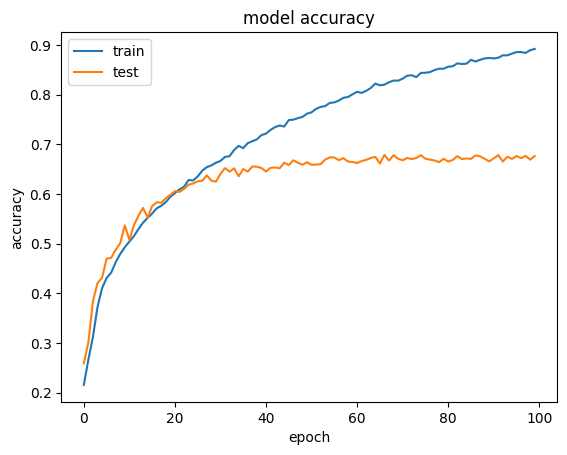

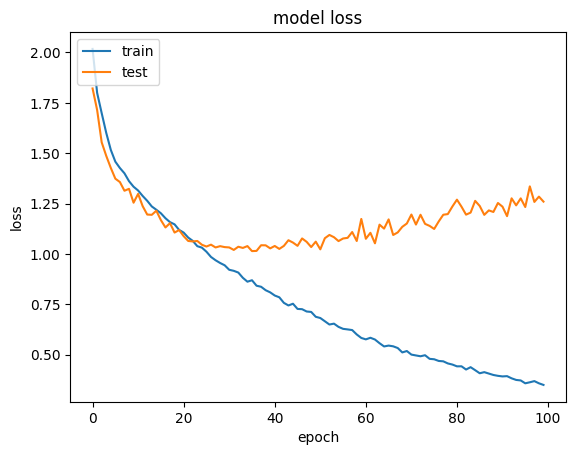

In [11]:
import matplotlib.pyplot as plt
history=hist_cnn

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
xTrain = np.reshape(X_train, (X_train.shape[0], 48,48,1))
xValid = np.reshape(X_valid, (X_valid.shape[0], 48,48,1))
xTest = np.reshape(X_test, (X_test.shape[0], 48,48,1))
yTrain = np.argmax(y_train, axis=1)
yValid = np.argmax(y_valid, axis=1)
yTest = np.argmax(y_test, axis=1)

y = y_train[2000]
indices_for_pos = np.squeeze(np.where(y_train == y))
indices_for_pos.shape
indices_for_pos

array([[    0,     0,     0, ..., 29067, 29067, 29067],
       [    0,     1,     2, ...,     2,     4,     5]])

In [13]:
y_train.shape

(29068, 7)

In [14]:
yTrain = np.argmax(y_train, axis=1)
yTrain[:10]

array([3, 5, 0, 4, 2, 5, 6, 4, 4, 4])

In [15]:
np.squeeze(np.where(y_train == y))

array([[    0,     0,     0, ..., 29067, 29067, 29067],
       [    0,     1,     2, ...,     2,     4,     5]])

## Test FER

In [27]:
from keras.models import model_from_json
# reads a model and its weights stored at path as name of file
# with .json for model and .h5 for weights
def load_model(path = pathname, file='fer'):
  json_file = open(path+file+'.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # load weights into new model
  loaded_model.load_weights(path+file+'.h5')
  print("Loaded model from disk")
  return loaded_model

loaded_model = load_model()

# load json and create model
from __future__ import division
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os
import numpy as np

json_file = open(pathname+'fer.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(pathname+"fer.h5")
print("Loaded model from disk")

truey=[]
predy=[]
x = np.load(pathname+'modXtest.npy')
y = np.load(pathname+'modytest.npy')

yhat= loaded_model.predict(x)
yh = yhat.tolist()
yt = y.tolist()
count = 0

for i in range(len(y)):
    yy = max(yh[i])
    yyt = max(yt[i])
    predy.append(yh[i].index(yy))
    truey.append(yt[i].index(yyt))
    if(yh[i].index(yy)== yt[i].index(yyt)):
        count+=1

acc = (count/len(y))*100

#saving values for confusion matrix and analysis
np.save(pathname+'truey', truey)
np.save(pathname+'predy', predy)
print("Predicted and true label values saved")
print("Accuracy on test set :"+str(acc)+"%")


Loaded model from disk
Loaded model from disk
113/113 [==============================] - 2s 11ms/step
Predicted and true label values saved
Accuracy on test set :66.00724435775982%


Loaded model from disk
Image Loaded
1/1 [==============================] - 0s 316ms/step
Emotion: Happy


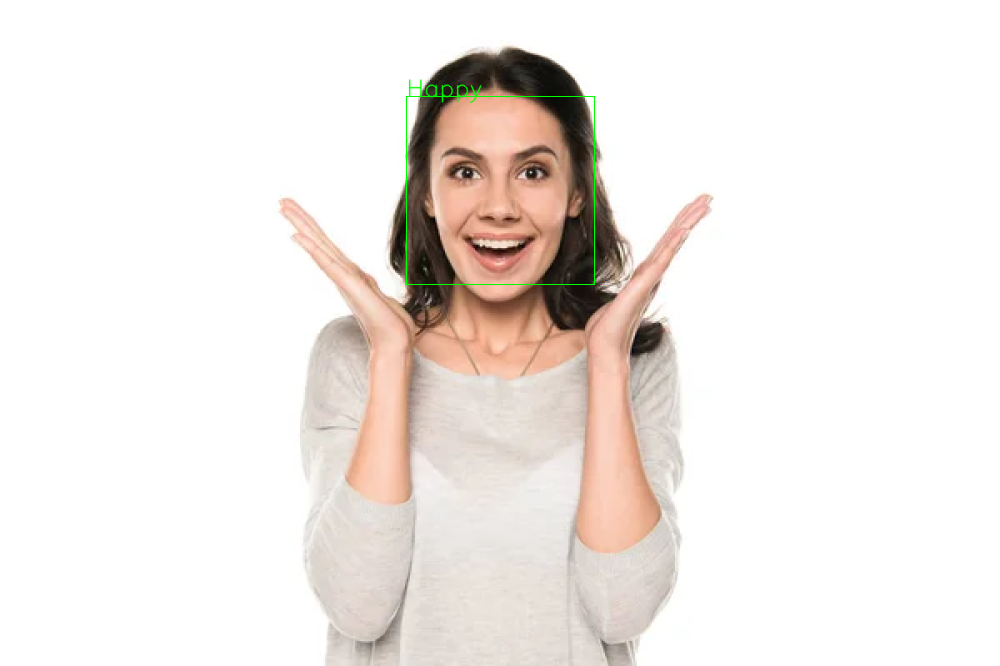

In [28]:
# load json and create model
from __future__ import division
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

#loading the model
json_file = open(pathname+'fer.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(pathname+"fer.h5")
print("Loaded model from disk")

#setting image resizing parameters
WIDTH = 48
HEIGHT = 48
x=None
y=None
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

#loading image
full_size_image = cv2.imread('happy.jpg') #
full_size_image = image_resize(full_size_image, width=1000)
print("Image Loaded")
gray=cv2.cvtColor(full_size_image,cv2.COLOR_RGB2GRAY)
face = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face.detectMultiScale(gray, 1.3, 5)

#detecting faces
for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
        cv2.rectangle(full_size_image, (x, y), (x + w, y + h), (0, 255, 0), 1)
        #predicting the emotion
        yhat= loaded_model.predict(cropped_img)
        cv2.putText(full_size_image, labels[int(np.argmax(yhat)+1)], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1, cv2.LINE_AA)
        print("Emotion: "+labels[
            (np.argmax(yhat)+1)])

cv2_imshow(full_size_image)

# Part 2: Lie Detection in Video

## Preprocessing

In [6]:
import pandas as pd

# define paths
video_path = "/content/drive/MyDrive/Liesss/Videos/Real-life_Deception_Detection_2016/Truth+lie/"
whole_video_path = "/content/drive/MyDrive/Liesss/Videos/Whole_Videos/"
project_path = "/content/drive/MyDrive/Liesss/"

video_dir_path = "/content/drive/MyDrive/Liesss/Videos/Real-life_Deception_Detection_2016/Annotation/Label.csv"


In [31]:
video_data = pd.read_csv(video_dir_path)
print(video_data)


video_filenames = video_data['id'].tolist()
labels = [1 if x == 'truthful' else 0 for x in video_data['class'].tolist()]

video_dict = dict(zip(video_filenames, labels))
print(video_dict)

                      id  OtherGestures  Smile  Laugh  Scowl  \
0      trial_lie_001.mp4              1      0      0      0   
1      trial_lie_002.mp4              1      0      0      0   
2      trial_lie_003.mp4              1      0      0      0   
3      trial_lie_004.mp4              1      0      0      0   
4      trial_lie_005.mp4              1      0      0      0   
..                   ...            ...    ...    ...    ...   
116  trial_truth_056.mp4              1      0      0      0   
117  trial_truth_057.mp4              1      0      0      0   
118  trial_truth_058.mp4              1      0      0      0   
119  trial_truth_059.mp4              0      0      0      1   
120  trial_truth_060.mp4              0      1      0      0   

     otherEyebrowMovement  Frown  Raise  OtherEyeMovements  Close-R  ...  \
0                       1      0      0                  1        0  ...   
1                       0      1      0                  1        0  ...   
2  

### Read all videos and extract facial images

Read all videos and extract facial images, preprocessed to 48 x 48 black and white images and saved as numpy arrays.

In [35]:
def preprocess_image(img):
  gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # we turn the image to grayscale
  cropped_img = np.expand_dims(np.expand_dims(cv2.resize(gray_img, (48, 48)), -1), 0)
  cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
  return cropped_img

# Given a filename, reads the video and captures frames from it
# For each frame, extracts a facial image if available
# Saves the cropped facial image
def read_video(filename, max_frames=300):
  cam = cv2.VideoCapture(whole_video_path+filename)
  currentframe = 0

  xdata = np.zeros((max_frames, 48*48))
  while(True):
    ret, frame_image = cam.read()

    if currentframe >= max_frames: break # limit the max number of frames we examine

    if ret: # a frame is found.

      # detect a primary face from the given frame image (if any)
      (detected, rect) = get_face_from_image(frame_image)
      # print(f"frame.shape={frame.shape}")

      # yhat = np.zeros((1, 7))

      x = np.zeros(48*48)
      # if a face is detected for the frame, crop the image
      if detected:
        (x, y, w, h) = rect
        cropped_face = frame_image[y:y+h, x:x+w]
        cropped_img = preprocess_image(cropped_face) # the low-res result ready for prediction
        # print(f'cropped_img shape={cropped_img.shape}')
        x = cropped_img.flatten()

      xdata[currentframe, :] = x
      # xdata[currentframe, :, :] = yhat

      currentframe+=1

    else: # we've reached the end of the video.
      break
  cam.release()

  return xdata


def saveData(X, y):
  X = np.asarray(X)
  y = np.asarray(y)
  np.save(project_path+'fdataX', X)
  np.save(project_path+'flabels', y)
  print(f'Saving X and y of shape {X.shape}, {y.shape}, respectively.')


X = []
y = []

count = 0
for (k, v) in video_dict.items():
  count+=1
  print(k, v)
  xi = read_video(k)
  X.append(xi)
  y.append(v)
  if count % 5 == 0:
    saveData(X, y)



saveData(X, y)


trial_lie_001.mp4 0
trial_lie_002.mp4 0
trial_lie_003.mp4 0
trial_lie_004.mp4 0
trial_lie_005.mp4 0
Saving X and y of shape (5, 300, 2304), (5,), respectively.
trial_lie_006.mp4 0
trial_lie_007.mp4 0
trial_lie_008.mp4 0
trial_lie_009.mp4 0
trial_lie_010.mp4 0
Saving X and y of shape (10, 300, 2304), (10,), respectively.
trial_lie_011.mp4 0
trial_lie_012.mp4 0
trial_lie_013.mp4 0
trial_lie_014.mp4 0
trial_lie_015.mp4 0
Saving X and y of shape (15, 300, 2304), (15,), respectively.
trial_lie_016.mp4 0
trial_lie_017.mp4 0
trial_lie_018.mp4 0
trial_lie_019.mp4 0
trial_lie_020.mp4 0
Saving X and y of shape (20, 300, 2304), (20,), respectively.
trial_lie_021.mp4 0
trial_lie_022.mp4 0
trial_lie_023.mp4 0
trial_lie_024.mp4 0
trial_lie_025.mp4 0
Saving X and y of shape (25, 300, 2304), (25,), respectively.
trial_lie_026.mp4 0
trial_lie_027.mp4 0
trial_lie_028.mp4 0
trial_lie_029.mp4 0
trial_lie_030.mp4 0
Saving X and y of shape (30, 300, 2304), (30,), respectively.
trial_lie_031.mp4 0
trial_lie_

In [1]:
#run this during execution
import sys, os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.models import model_from_json
import tensorflow as tf

# define paths
video_path = "/content/drive/MyDrive/Liesss/Videos/Real-life_Deception_Detection_2016/Truth+lie/"
whole_video_path = "/content/drive/MyDrive/Liesss/Videos/Whole_Videos/"
project_path = "/content/drive/MyDrive/Liesss/"
pathname = '/content/drive/MyDrive/Liesss/'
video_dir_path = "/content/drive/MyDrive/Liesss/Videos/Real-life_Deception_Detection_2016/Annotation/Label.csv"


#loading the model
json_file = open(pathname+'fer.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(pathname+"fer.h5")
print("Loaded model from disk")

Loaded model from disk


## Train DNN

In [2]:
#Load saved facial sequence data
X = np.load(project_path+'fdataX.npy')
y = np.load(project_path+'flabels.npy')

print('Loaded data', X.shape, y.shape)

Loaded data (121, 300, 2304) (121,)


In [3]:
X = np.reshape(X,(X.shape[0], X.shape[1], 48, 48))
X = np.expand_dims(X, -1)
X.shape

(121, 300, 48, 48, 1)

In [4]:
import sys, os
import pandas as pd
import numpy as np
from tensorflow.keras import initializers
from keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Masking, GRU
from keras.layers import Conv1D, Conv2D, Conv3D, MaxPooling1D, MaxPooling2D, MaxPooling3D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.models import model_from_json
import tensorflow as tf
import matplotlib.pyplot as plt

In [5]:
# load the layers from the pre-trained, loaded model
layer_names = [layer.name for layer in loaded_model.layers]
layer_outputs = [layer.output for layer in loaded_model.layers]
print(f"layer_names total: {len(layer_names)}")

# pre-process input X
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

# for each entry, we will convert each of the 300 images (48, 48, 1) to encoding vectors
encoding_model = Model(inputs = loaded_model.inputs, outputs = layer_outputs[23])

X_cnn = np.zeros((X.shape[0], X.shape[1], 4608))
i = 0
for (xi, yi) in zip(X, y):
  # print(f"xi.shape={xi.shape}, yi.shape={yi.shape}, yi={yi}")
  predictedX = encoding_model.predict(xi)
  X_cnn[i] = predictedX
  i+=1


#splitting into training, validation and testing data
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.1, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=7)

#saving the test samples to be used later
np.save(project_path+'modXtest', X_test)
np.save(project_path+'modytest', y_test)

layer_names total: 31
10/10 [==============================] - 0s 6ms/step


In [6]:
print(X_train.shape, y_train.shape)
m = X_train.shape[0]
Tx = X_train.shape[1]
dims = X_train.shape[2]

(97, 300, 4608) (97,)


## Siamese Network with Triplet Loss for Classification

First we generate dataset for the triplet loss.

Then we train a 2-layer GRU model to output a 128-dim encoding vector for each preprocessed video input.

Finally, we store the average encoding vector for positive and negative classes for later use.



---



Whenever there is a new video, we simply

1) get the preprocessed video as a vector

2) compare the distance(average_positive_encoding, video_encoding) vs. distance(average_negative_encoding, video_encoding) to assign a label 0 or 1.

In [7]:
# Data preprocessing
X_train = X_train.reshape(X_train.shape[0], 300, 4608)
print(X_train.shape, y_train.shape)
input_shape = X_train.shape[1:]
print(f"input_shape={input_shape}")

X_valid = X_valid.reshape(X_valid.shape[0], 300, 4608)

(97, 300, 4608) (97,)
input_shape=(300, 4608)


In [8]:
import random

# Returns a list of randomly generated anchors, positives and negatives
# of size batch_size (default to 5000)
def create_batch(batch_size=5000):
    x_anchors = np.zeros((batch_size, 300, 4608))
    x_positives = np.zeros((batch_size, 300, 4608))
    x_negatives = np.zeros((batch_size, 300, 4608))

    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, X_train.shape[0] - 1)
        x_anchor = X_train[random_index]
        y = y_train[random_index]

        indices_for_pos = np.squeeze(np.where(y_train == y))
        indices_for_neg = np.squeeze(np.where(y_train != y))

        x_positive = X_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = X_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]

        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative

    return [x_anchors, x_positives, x_negatives]

In [9]:
emb_size = 64

def create_embedding_model(input_shape):
  X_input = Input(shape=input_shape)
  X = Conv1D(filters=96, kernel_size=15, strides=4)(X_input) #filters = 196, kernel_size = 15
  # X = MaxPooling1D(pool_size=15)(X)
  X = MaxPooling1D(pool_size=30, strides=15, padding='valid')(X) # pool 30, strides 15 is fine!
  X = BatchNormalization()(X)
  X = Activation("relu")(X)
  X = Dropout(rate=0.8)(X)

  X = GRU(units=128, return_sequences=True)(X)
  X = Dropout(rate=0.8)(X)
  X = BatchNormalization()(X)

  X = GRU(units=128, return_sequences=True)(X)
  X = Dropout(rate=0.8)(X)
  X = BatchNormalization()(X)

  X = Dropout(rate=0.5)(X)

  X = Flatten()(X)
  X = Dense(emb_size, activation="sigmoid")(X)

  model = Model(inputs=X_input, outputs=X)

  return model

embedding_model=create_embedding_model(input_shape=(Tx, dims))
embedding_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 4608)]       0         
                                                                 
 conv1d (Conv1D)             (None, 72, 96)            6635616   
                                                                 
 max_pooling1d (MaxPooling1  (None, 3, 96)             0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 3, 96)             384       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 3, 96)             0         
                                                                 
 dropout (Dropout)           (None, 3, 96)             0   

In [10]:
# Siamese Network

input_anchor = Input(shape=(Tx, dims,))
input_positive = Input(shape=(Tx, dims,))
input_negative = Input(shape=(Tx, dims,))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)
net.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 300, 4608)]          0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 300, 4608)]          0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 300, 4608)]          0         []                            
                                                                                                  
 model_1 (Functional)        (None, 64)                   6847520   ['input_2[0][0]',             
                                                                     'input_3[0][0]',       

In [11]:
# Triplet Loss

alpha = 0.2

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

In [12]:
# Data Generator

def data_generator(batch_size=64):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y


In [14]:
# Model Training
batch_size = 50
epochs = 100
steps_per_epoch=1

net.compile(loss=triplet_loss, optimizer=Adam(learning_rate=3e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-7))


In [ ]:
# early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)


hist = net.fit(
    data_generator(batch_size),
    epochs=epochs, verbose=True,
    steps_per_epoch=steps_per_epoch,
    callbacks=[early_stopping_callback]
    )

Epoch 1/100


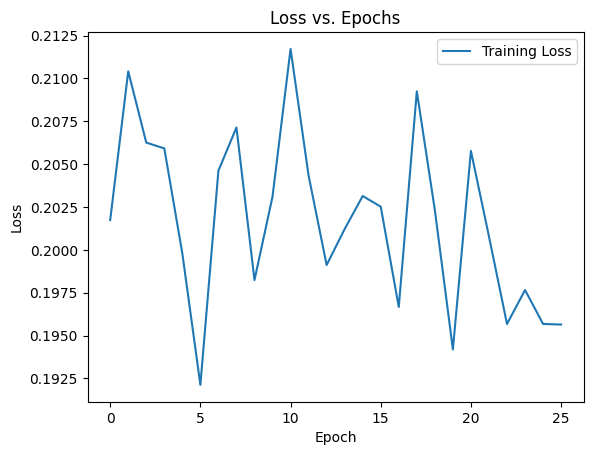

In [27]:
# Plot the loss vs. epochs
plt.plot(hist.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.show()

Store the average truth vector and the average lie vector learned with training set for verificiation

In [28]:
X_train_emb = embedding_model.predict(X_train)

truth_emb = []
lie_emb = []
for xi, yi in zip(X_train_emb, y_train):
  if yi == 1:
    truth_emb.append(xi)
  else:
    lie_emb.append(xi)
print(f"There are {len(truth_emb)} truths and {len(lie_emb)} lies.")

average_truth_emb = np.mean(truth_emb, axis=0)
average_lie_emb = np.mean(lie_emb, axis=0)

database={}
database['truth'] = average_truth_emb
database['lie'] = average_lie_emb

4/4 [==============================] - 0s 63ms/step
There are 51 truths and 46 lies.


In [ ]:
# Train accuracy
X_train_emb = embedding_model.predict(X_train)
print(f"X_train.shape={X_train.shape}, X_train_emb.shape={X_train_emb.shape}, y_train.shape={y_train.shape}")

# verify function: given an embedding, will tell whether or not it is truth
# based on distance from the average truth and the average lie vectors.
def verify(emb, embedding_model, database):
  dist_truth = np.linalg.norm(emb - database["truth"])
  dist_lie = np.linalg.norm(emb - database["lie"])
  print(f"dist_truth={dist_truth}, dist_lie={dist_lie}")
  return 1 if dist_truth < dist_lie  else 0

count = 0

y_pred = []
for emb, y in zip(X_train_emb, y_train):
  y_predict = verify(emb, embedding_model, database)
  y_pred.append(y_predict)
  if y_predict == y:
    count += 1
  else:
    print("y_predict: ", y_predict, "y: ", y)

accuracy = count/X_train_emb.shape[0]
acc_str = '%.2f' % (accuracy*100)
print('Train Accuracy: '+acc_str+'%')

Confusion matrix -Training dataset

In [21]:
#To calculate confusion matrix:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels = ['deceptive', 'truthful'], title='Confusion Matrix'):
  cm = confusion_matrix(y_true, y_pred)
  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=45)
  plt.yticks(tick_marks, labels)
  fmt = 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()
  plt.show()


[[36 10]
 [13 38]]


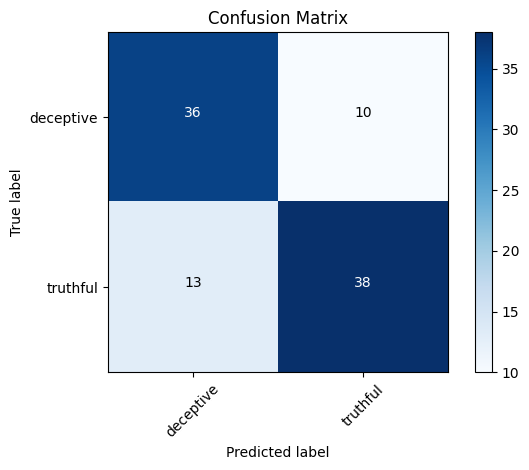

In [22]:
plot_confusion_matrix(np.array(y_train), np.array(y_pred), title='Confusion Matrix')

In [23]:
# Validation Accuracy
X_valid_emb = embedding_model.predict(X_valid)
print(f"X_valid.shape={X_valid.shape}, X_valid_emb.shape={X_valid_emb.shape}, y_valid.shape={y_valid.shape}")

# now we measure the accuracy on validation set.
count = 0
y_pred = []

for emb, y in zip(X_valid_emb, y_valid):
  y_predict = verify(emb, embedding_model, database)
  y_pred.append(y_predict)
  if y_predict == y:
    count += 1
  else:
    print("y_predict: ", y_predict, "y: ", y)


accuracy = count/X_valid_emb.shape[0]
acc_str = '%.2f' % (accuracy*100)
print('Validation Accuracy: '+acc_str+'%')

1/1 [==============================] - 0s 463ms/step
X_valid.shape=(11, 300, 4608), X_valid_emb.shape=(11, 64), y_valid.shape=(11,)
dist_truth=0.19119994342327118, dist_lie=0.36769264936447144
y_predict:  1 y:  0
dist_truth=0.347682386636734, dist_lie=0.3235280513763428
dist_truth=0.5663557648658752, dist_lie=0.4160950183868408
dist_truth=0.4762137532234192, dist_lie=0.3478494882583618
dist_truth=0.20411579310894012, dist_lie=0.40513667464256287
dist_truth=0.6544971466064453, dist_lie=0.48997336626052856
dist_truth=0.20411579310894012, dist_lie=0.40513667464256287
dist_truth=0.6077587008476257, dist_lie=0.49424928426742554
dist_truth=0.20860454440116882, dist_lie=0.37829670310020447
y_predict:  1 y:  0
dist_truth=0.38030120730400085, dist_lie=0.30960750579833984
dist_truth=0.6128767132759094, dist_lie=0.5752617716789246
Validation Accuracy: 81.82%


[[7 2]
 [0 2]]


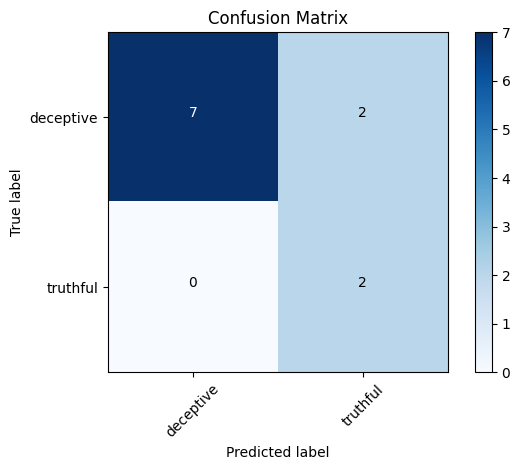

In [24]:
plot_confusion_matrix(np.array(y_valid), np.array(y_pred), title='Confusion Matrix')